In [1]:
from cftime import DatetimeNoLeap
from datetime import timedelta
from numpy import append, datetime64, empty, float32, float64, full, repeat, stack
from os import chdir, system
from scipy.interpolate import griddata
from warnings import simplefilter
from xarray import DataArray, open_dataset
simplefilter("ignore")

In [2]:
start_year = 2001
start_month = 1
start_day = 1

In [3]:
end_year = 2001
end_month = 1
end_day = 2

**paths**

In [4]:
nc_path = '/home/zhangc/cesm2_cmip6/nc_data/'
im_path = '/home/zhangc/cesm2_cmip6/im_data/'
os_path = '/home/zhangc/repositories/nc2im_cesm2/'

**data**

In [5]:
ncs = ['ta_6hrLev_CESM2_historical_r11i1p1f1_gn_200001010000-200912311800.nc',  #  0
       'hus_6hrLev_CESM2_historical_r11i1p1f1_gn_200001010000-200912311800.nc', #  1
       'ua_6hrLev_CESM2_historical_r11i1p1f1_gn_200001010000-200912311800.nc',  #  2
       'va_6hrLev_CESM2_historical_r11i1p1f1_gn_200001010000-200912311800.nc',  #  3
       'tos_Oday_CESM2_historical_r11i1p1f1_gn_20000102-20150101.nc',           #  4
       'siconc_SIday_CESM2_historical_r11i1p1f1_gn_20000102-20150101.nc',       #  5
       'snw_day_CESM2_historical_r11i1p1f1_gn_20000101-20150101.nc',            #  6
       'ts_Amon_CESM2_historical_r11i1p1f1_gn_200001-201412.nc',                #  7
       'tsl_Lmon_CESM2_historical_r11i1p1f1_gn_200001-201412.nc',               #  8
       'soil_mon_ERA5_2015.nc',                                                 #  9
       'landmask_CESM2.nc',                                                     # 10
       'phis_CESM2.nc']                                                         # 11

In [6]:
chdir(nc_path)

In [7]:
dss = []
for nc in ncs:
    ds = open_dataset(nc)
    dss.append(ds)

**datetime**

In [8]:
start_date = DatetimeNoLeap(start_year, start_month, start_day)
end_date = DatetimeNoLeap(end_year, end_month, end_day)

In [9]:
dates = []
date = start_date

In [10]:
while date <= end_date:
    dates.append(date)
    date += timedelta(hours=6)

In [11]:
date = dates[0]

In [12]:
tnum = date.year, date.month, date.day, date.hour
t6hr = DatetimeNoLeap(tnum[0], tnum[1], tnum[2], tnum[3])
tday = DatetimeNoLeap(tnum[0], tnum[1], tnum[2]) + timedelta(days=1)
if tnum[1] is 2:
    mid_day = 14
else:
    mid_day = 15
if tnum[1] in [1, 3, 5, 7, 8, 10, 12]:
    mid_hour = 12
else:
    mid_hour = 0
tmon = DatetimeNoLeap(tnum[0], tnum[1], mid_day, mid_hour)
tera = datetime64('2015-'+str(tnum[1]).zfill(2)+'-01')
file_time = str(t6hr).replace(' ', '_')

**land-sea mask**

In [13]:
v = dss[10].landmask.values
da = DataArray(name='ls', data=float32(v))
file_name = 'ls_' + file_time + '.nc'
da.to_netcdf(im_path+file_name)

**surface geopotential**

In [14]:
v = dss[11].phis.values
da = DataArray(name='phis', data=float32(v))
file_name = 'phis_' + file_time + '.nc'
da.to_netcdf(im_path+file_name)

**soil height**

In [15]:
v = dss[11].phis.values/9.80655
da = DataArray(name='sh', data=float32(v))
file_name = 'sh_' + file_time + '.nc'
da.to_netcdf(im_path+file_name)

**time**

In [16]:
ds = dss[0].sel(time=t6hr)
da = ds.ta
file_name = 'time_' + file_time + '.nc'
da.to_netcdf(im_path+file_name)

**horizontal coordinates**

In [17]:
ss = ['lon', 'lat']

In [18]:
for s in ss:  
    v = ds[s].values
    da = DataArray(name=s, data=float64(v))
    file_name = s + '_' + file_time + '.nc'
    da.to_netcdf(im_path+file_name)

**vertical coordinates**

In [19]:
v = ds.a.values
da = DataArray(name='hyam', data=float32(v))
file_name = 'hyam' + '_' + file_time + '.nc'
da.to_netcdf(im_path+file_name)

In [20]:
v = ds.b.values
da = DataArray(name='hybm', data=float32(v))
file_name = 'hybm' + '_' + file_time + '.nc'
da.to_netcdf(im_path+file_name)

In [21]:
v0 = ds.a_bnds.values[:,0]
v1 = ds.a_bnds.values[:,1]
v = append(v1, v0[-1])
da = DataArray(name='hyai', data=float32(v))
da.to_netcdf(im_path+file_name)

In [22]:
v0 = ds.b_bnds.values[:,0]
v1 = ds.b_bnds.values[:,1]
v = append(v1, v0[-1])
da = DataArray(name='hybi', data=float32(v))
da.to_netcdf(im_path+file_name)

**surface pressure**

In [23]:
v = ds.ps.values
da = DataArray(name='ps', data=float32(v))
file_name = 'ps_' + file_time + '.nc'
da.to_netcdf(im_path+file_name)

**3d pressure**

In [24]:
a = ds.a.values
b = ds.b.values
ps = ds.ps.values
p0 = full(ps.shape, ds.p0.values)

In [25]:
shape = ds.ta.shape
v = empty(shape)
for i in range(shape[0]):
    v[i] = a[i]*p0 + b[i]*ps

In [26]:
da = DataArray(name='p', data=float32(v))
file_name = 'p_' + file_time + '.nc'
da.to_netcdf(im_path+file_name)

**3d temperature**

In [27]:
v = ds.ta.values
da = DataArray(name='ta', data=float32(v))
file_name = 'ta_' + file_time + '.nc'
da.to_netcdf(im_path+file_name)

**3d humidity**

In [28]:
v = dss[1].hus.sel(time=t6hr).sortby('lev').values
da = DataArray(name='hus', data=float32(v))
file_name = 'hus_' + file_time + '.nc'
da.to_netcdf(im_path+file_name)

**3d winds**

In [29]:
v = dss[2].ua.sel(time=t6hr).sortby('lev').values
da = DataArray(name='ua', data=float32(v))
file_name = 'ua_' + file_time + '.nc'
da.to_netcdf(im_path+file_name)

In [30]:
v = dss[3].va.sel(time=t6hr).sortby('lev').values
da = DataArray(name='va', data=float32(v))
file_name = 'va_' + file_time + '.nc'
da.to_netcdf(im_path+file_name)

**3d virtual temperature**

In [31]:
t = dss[0].ta.sel(time=t6hr).values
q = dss[1].hus.sel(time=t6hr).sortby('lev').values
tv = t*(1.+q*0.61)
da = DataArray(name='tv', data=float32(tv))
file_name = 'tv_' + file_time + '.nc'
da.to_netcdf(im_path+file_name)

**skin temperature**

In [32]:
v = dss[7].ts.sel(time=tmon).values
da = DataArray(name='ts', data=float32(v))
file_name = 'ts_' + file_time + '.nc'
da.to_netcdf(im_path+file_name)

**sea surface temperature**

In [60]:
ds = dss[4].tos.sel(time=tday)
x = ds.lon.values.flatten()
y = ds.lat.values.flatten()
xy = stack((x, y), axis=-1)
v = ds.values.flatten() + 273.15

In [56]:
lon1d = dss[0].lon.values
lat1d = dss[0].lat.values
nx = len(lon1d)
ny = len(lat1d)
lon2d = repeat(lon1d, ny).reshape(nx, ny).transpose()
lat2d = repeat(lat1d, nx).reshape(ny, nx)

In [57]:
vi = griddata(xy, v, (lon2d, lat2d), method='linear')
da = DataArray(name='sst', data=float32(vi))
daf = da.fillna(0.)
file_name = 'sst_' + file_time + '.nc'
daf.to_netcdf(im_path+file_name)

**sea ice concentration**

In [38]:
ds = dss[5].siconc.sel(time=tday)
v = da.values.flatten()*0.01
vi = griddata(xy, v, (lon2d, lat2d), method='linear')
da = DataArray(name='sic', data=float32(vi))
daf = da.fillna(0.)
file_name = 'sic_' + file_time + '.nc'
daf.to_netcdf(im_path+file_name)

**surface snow amount**

In [40]:
v = dss[6].snw.sel(time=tday).values
da = DataArray(name='snw', data=float32(v))
daf = da.fillna(0.)
file_name = 'snw_' + file_time + '.nc'
daf.to_netcdf(im_path+file_name)

**soil moisture**

In [41]:
ds = dss[9].sel(time=tera)
ss = ['swvl1', 'swvl2', 'swvl3', 'swvl4']

In [42]:
for s in ss:
    v = ds[s].interp(longitude=lon1d, latitude=lat1d).values
    da = DataArray(name=s, data=float32(v))
    daf = da.fillna(0.)
    file_name = s + '_' + file_time + '.nc'
    daf.to_netcdf(im_path+file_name)

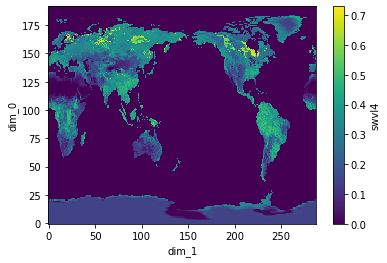

In [43]:
daf.plot()

**soil temperature**

In [ ]:
ds = dss[8].tsl.sel(time=tmon)
ss = ['tsl0', 'tsl1', 'tsl2', 'tsl3']

In [ ]:
for i in range(4):
    v = ds.isel(depth=i).values
    da = DataArray(name=ss[i], data=float32(v))
    daf = da.fillna(0.)
    file_name = ss[i] + '_' + file_time + '.nc'
    daf.to_netcdf(im_path+file_name)

In [ ]:
daf.plot()

In [ ]:
#chdir(os_path)

In [ ]:
#command = 'ncl write_im.ncl ' + "'file_time=" + '"' + file_time + '"' + "'"

In [ ]:
#system(command)